In [1]:
import os
import pypsa
import random
import requests
import numpy as np
import pandas as pd
from io import StringIO
import geopandas as gpd
from pathlib import Path
import matplotlib as mpl
import matplotlib.pyplot as plt

In [2]:
date = '2024-02-18'
period = 17

In [3]:
def get_price(date, period):

    price_template = "https://data.elexon.co.uk/bmrs/api/v1/balancing/pricing/market-index?from={}T00:00Z&to={}T00:00Z&settlementPeriodFrom={}&settlementPeriodTo={}"

    url = price_template.format(date, date, period, period)
    response = requests.get(url)
    df = pd.read_csv(StringIO(response.text))

    for col1, col2 in zip(df.columns[:-1], df.columns[1:]):
        if not ('price' in col1 and 'volume' in col2):
            continue
        print(col2)

        return float(col1.split(':')[-1])


def get_bm_data(date, period):
    data = pd.read_csv(Path.cwd().parent / 'resources' / 'live_data' / f'{date}_{period}' / 'elexon_bmus.csv', index_col=0)

    return data['PN']


price = get_price(date, period)

volume:1900.450}


In [4]:
def get_model(date, period, layout='nodal'):
    return pypsa.Network(Path.cwd().parent / 'resources' / 'live_data' / f'{date}_{period}' / f'network_s_{layout}_solved.nc')

n = get_model(date, period)

carrier_grouper = {
    'hydro': 'hydro',
    'hydro-scheme': 'hydro',
    'wind': 'offwind',
    'floating wind': 'offwind',
    'CCGT': 'gas',
    'powerstation': 'gas',
    'gas turbine': 'gas',
    'gas-fired': 'gas',
    'solar power station': 'solar',
    'PV': 'solar',
    'PHS': 'hydro',
    'dam': 'hydro',
}

n.generators['carrier'] = n.generators.carrier.map(lambda x: carrier_grouper[x] if x in carrier_grouper else x)

colors = {
    "onwind": "#235ebc",
    "offwind": "#6895dd",
    "hydro": "#298c81",
    "CHP": "#8a5751",
    "coal": "#545454",
    "biomass": "#baa741",
    "gas": "#a85522",
    "nuclear": '#ff8c00',
    "interconnector": "#8a1caf",
    "cascade": "#46caf0",
    "solar": "#f9d002",
    "battery": '#ace37f',
}

Index(['BLARW-1'], dtype='object', name='name')
INFO:pypsa.io:Imported network network_s_nodal_solved.nc has buses, carriers, generators, lines, links, loads


In [5]:
bmu_loc = pd.read_csv(Path.cwd().parent / 'resources' / 'bmunits_loc.csv', index_col=0)[['lat', 'lon']]

Index(['BLARW-1'], dtype='object', name='name')
INFO:pypsa.io:Imported network network_s_nodal_solved.nc has buses, carriers, generators, lines, links, loads
Index(['BLARW-1'], dtype='object', name='name')
INFO:pypsa.io:Imported network network_s_eso_solved.nc has buses, carriers, generators, lines, links, loads
Index(['BLARW-1'], dtype='object', name='name')
INFO:pypsa.io:Imported network network_s_fti_solved.nc has buses, carriers, generators, lines, links, loads
Index(['BLARW-1'], dtype='object', name='name')
INFO:pypsa.io:Imported network network_s_national_solved.nc has buses, carriers, generators, loads


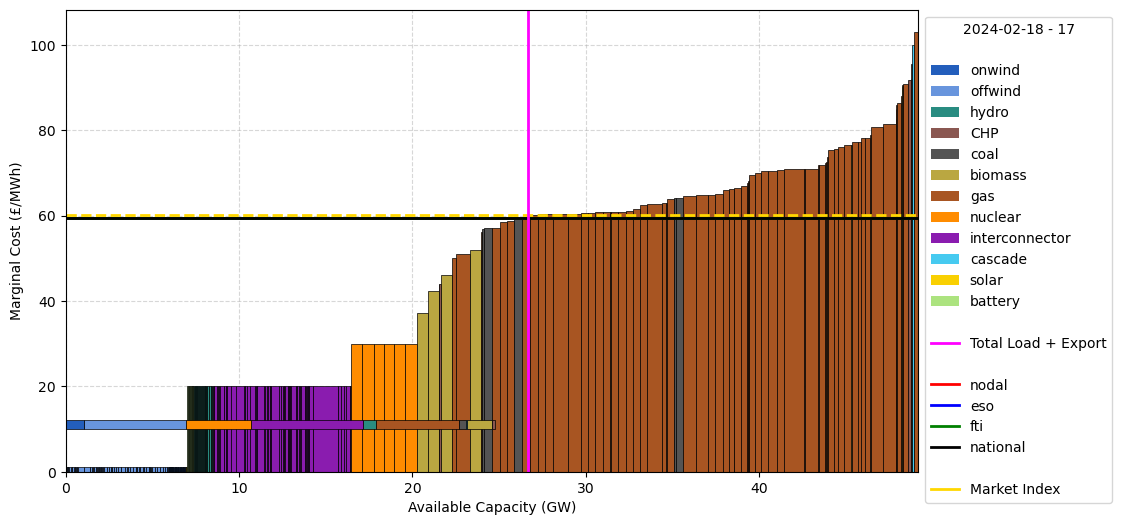

In [6]:
from shapely.geometry import Point

fig, ax = plt.subplots(1, 1, figsize=(11, 6))

bm_data = get_bm_data(date, period)

gen = n.generators.sort_values(by=['marginal_cost', 'carrier'])
gen = pd.concat((
    gen, n.generators_t.p.T.rename(columns={n.generators_t.p.index[0]: 'p'})
), axis=1)
gen.drop(gen[gen.p_nom == 0].index, inplace=True)

gen = pd.concat((gen, bmu_loc.loc[gen.index], bm_data.loc[gen.index].mul(1e-3)), axis=1)
gen["geometry"] = gen.apply(lambda x: Point(x.lon, x.lat), axis=1)

gen[["p_nom", "p"]] *= 1e-3

gen['diff'] = gen['p_nom'] - gen['p']

gen['total_p_nom'] = gen['p_nom'].cumsum()
gen['total_p'] = gen['p'].cumsum()

col = 'p_nom'

for i, (bmu, row) in enumerate(gen.iterrows()):
    
    ax.bar(
        # row.total_p_nom - row.p_nom/2,
        row['total_'+col] - row[col]/2,
        max(row.marginal_cost, 1),
        width=row[col],
        # bottom=row.total_p_nom - row.p_nom,
        color=colors[row.carrier],
        edgecolor='black',
        linewidth=0.5,
        )

handles = []
labels = []
labels.append('')
handles.append(plt.Line2D([0], [0], color='w', lw=0, label=''))

for color, carrier in zip(colors.values(), colors.keys()):
    if not carrier in gen.carrier.values:
        continue

    handles.append(plt.Rectangle((0, 0), 1, 1, fc=color))
    labels.append(carrier)

labels.append('')
handles.append(plt.Line2D([0], [0], color='w', lw=0, label=''))

load_color = 'magenta'
labels.append('Total Load + Export')
handles.append(plt.Line2D([0], [0], color=load_color, lw=2, label=''))

labels.append('')
handles.append(plt.Line2D([0], [0], color='w', lw=0, label=''))


lcolors = {
    'national': 'black',
    'eso': 'blue',
    'fti': 'green',
    'nodal': 'red',
}

for l in ['nodal', 'eso', 'fti', 'national']:
    ln = get_model(date, period, layout=l)

    max_price = ln.buses_t.marginal_price.max().max()
    ax.axhline(max_price, color=lcolors[l], lw=2)

    handles.append(plt.Line2D([0], [0], color=lcolors[l], lw=2))
    labels.append(l)

ax.axhline(price, color='gold', lw=2, linestyle='--')
labels.append('')
handles.append(plt.Line2D([0], [0], color='w', lw=0, label='', linestyle='--'))

labels.append('Market Index')
handles.append(plt.Line2D([0], [0], color='gold', lw=2))

ax.legend(
    handles,
    labels,
    loc='upper left',
    bbox_to_anchor=(1, 1),
    title=f'{date} - {period}',
    )

ax.set_xlabel('Available Capacity (GW)')
ax.set_ylabel('Marginal Cost (£/MWh)')

exporters = n.generators.index[n.generators.p_max_pu == -1.]
export_vol = n.generators_t.p[exporters].sum().sum() * 1e-3

ax.axvline(n.loads.p_set.sum() * 1e-3 + 2*abs(export_vol), color=load_color, lw=2)
ax.set_xlim(0, gen.p_nom.sum())

ax.grid(True, linestyle='--', alpha=0.5)
ax.set_axisbelow(True)

# ax.axvline(bm_data.loc[bm_data > 0].sum()*1e-3, color=load_color, lw=5)
carrier_dispatch = (
    pd.concat((
        gen[['carrier', 'p_nom', 'marginal_cost']],
        bm_data.mul(1e-3)
        ), axis=1)
    .loc[gen.index]
    .groupby('carrier')[['PN']].sum()
    .iloc[::-1]
)

carrier_dispatch['total'] = carrier_dispatch.cumsum()

for carrier, row in carrier_dispatch.loc[gen.carrier.unique()].iterrows():
    ax.bar(row.total - row.PN/2, 2, width=row.PN, bottom=10, color=colors[carrier], edgecolor='black', linewidth=0.5)

plt.show()

In [149]:
(g := gen.loc[gen['p'] >=0]).loc[g['diff'] > 0].sort_values(by='marginal_cost', ascending=True)[['diff', 'marginal_cost', 'p_nom', 'p']]

,diff,marginal_cost,p_nom,p
Generator,,,,
BLARW-1,0.01000,0.010000,0.010,0.00000
HYWDW-1,0.02900,0.010000,0.029,0.00000
SGRWO-2,0.06900,0.010000,0.069,0.00000
SGRWO-5,0.01185,0.010000,0.079,0.06715
TULWW-1,0.00900,0.010000,0.009,0.00000
...,...,...,...,...
FAWN-1,0.12500,102.592597,0.125,0.00000
CROYD-2,0.04500,103.978004,0.045,0.00000
FDUNT-1,0.04400,106.961824,0.044,0.00000


In [159]:
cols = ['p_nom', 'p', 'PN']

inter = gen.loc[gen.carrier == 'interconnector', cols]

inter = inter.groupby(inter.index.str[:3]).sum()

print(inter.loc[inter['p'] >= 0])
print(inter.loc[inter['p'] < 0])

           p_nom      p     PN
Generator                     
IBG        0.934  0.934  0.934
IFG        1.901  1.901  1.901
ILG        0.815  0.815  0.815
ING        0.834  0.834  0.834
IVG        0.153  0.153  0.153
           p_nom      p     PN
Generator                     
IBD        0.746 -0.746 -0.746
IED        0.980 -0.980 -0.980
IND        0.428 -0.428 -0.428
IVD        0.955 -0.955 -0.955


In [150]:
def get_wholesale_price(n):

    marginal_prices = n.buses_t.marginal_price.iloc[0]
    weights = n.loads.p_set / n.loads.p_set.sum()

    return (marginal_prices * weights).sum()


get_wholesale_price(n)


51.28421809926371

c:\Users\lukas\miniforge3\envs\pypsa-eur\lib\site-packages\IPython\core\interactiveshell.py:3526: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


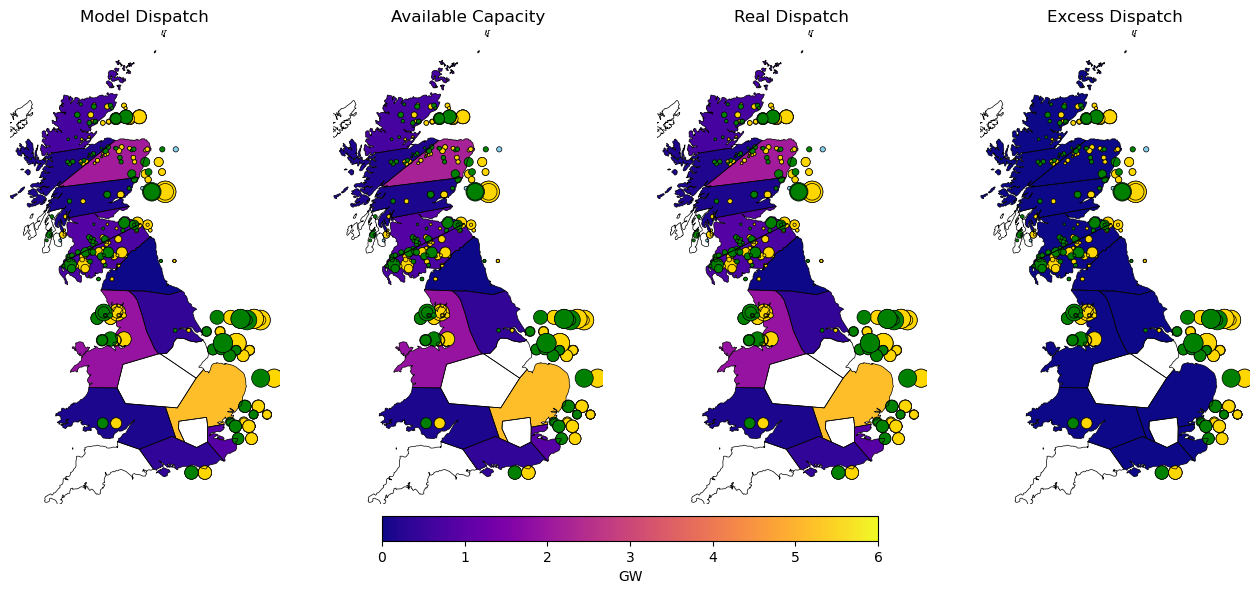

In [140]:
regions = gpd.read_file(Path.cwd().parent / 'data' / 'eso_zones.geojson').set_crs(epsg=4326)
all_regions = regions.copy()

buses = gpd.GeoDataFrame(
    n.buses,
    geometry=gpd.points_from_xy(n.buses.x, n.buses.y)
    )

wind = gpd.GeoDataFrame(
    gen.loc[gen.carrier.str.contains('wind')],
    geometry='geometry',
    crs='EPSG:4326'
)
wind_farms = wind.copy()
wind = wind.loc[wind.bus != '']

wind['geometry'] = wind['bus'].apply(lambda x: buses.loc[x].geometry)

regions = regions.sjoin(wind[["carrier", 'marginal_cost', "p_nom", 'p', 'PN', 'geometry', 'diff']], how='inner', op='intersects')

regions["excess"] = regions['p'] - regions['PN']

regions = regions.groupby('name')[['p_nom', 'p', 'excess', 'PN', 'geometry']].agg({
    'p_nom': 'sum',
    'p': 'sum',
    'excess': 'sum',
    'PN': 'sum',
    'geometry': 'first'
})

regions = gpd.GeoDataFrame(regions, crs='EPSG:4326')

fig, axs = plt.subplots(1, 4, figsize=(16, 15))

vmin = 0.
vmax = np.ceil(regions['PN'].max())
titles = {
    'p': 'Model Dispatch',
    'p_nom': 'Available Capacity',
    'PN': 'Real Dispatch',
    'excess': 'Excess Dispatch',

}

cm = 'plasma'
for ax, col in zip(axs, ['p', 'p_nom', 'PN', 'excess']):

    regions.plot(
        ax=ax,
        column=col,
        cmap=cm,
        # legend=True,
        # legend_kwds={'label': "GW", 'orientation': "horizontal"},
        # edgecolor='black',
        linewidth=0.5,
        vmin=vmin,
        vmax=vmax,
        )

    xoff = 0.5
    (
        wind_farms
        .translate(xoff=xoff, yoff=0.0)
        .plot(
            ax=ax,
            color='skyblue',
            markersize=wind_farms['p_nom']*500,
            # alpha=0.5,
            edgecolor='black',
            linewidth=0.5
            )
    )

    (
        wind_farms
        .translate(xoff=xoff, yoff=0.0)
            .plot(
            ax=ax,
            color='gold',
            markersize=wind_farms['p']*500,
            # alpha=0.5,
            edgecolor='black',
            linewidth=0.5
            )
    )

    (
        wind_farms
        #.translate(xoff=0.1, yoff=0.1)
        .plot(
            ax=ax,
            color='green',
            markersize=wind_farms['PN']*500,
            alpha=1,
            edgecolor='black',
            linewidth=0.5
        )
    )
    
    ax.set_title(titles[col])

    ax.set_xlim(-7, 3)
    ax.set_ylim(50, 60)

    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)

    ax.set_xticks([])
    ax.set_yticks([])

    all_regions.boundary.plot(ax=ax, color='black', linewidth=0.5)


fig.colorbar(
    mpl.cm.ScalarMappable(
        norm=mpl.colors.Normalize(vmin, vmax),
        cmap=cm),
        ax=axs[:],
        orientation='horizontal',
        label='GW',
        shrink=0.4,
        pad=0.01,
        )

plt.savefig('wind_dispatch.pdf')
plt.show()

In [163]:
balancing = pd.read_csv(Path.cwd().parent / 'resources' / 'live_data' / f'{date}_{period}' / 'real_balancing_actions.csv', index_col=0)
pd.concat((balancing, n.generators.loc[balancing.index.intersection(n.generators.index), ['carrier']]), axis=1)

,offer volume,offer price,bid volume,bid price,offer revenue,bid revenue,carrier
WBURB-3,0.416667,82.00,0.000000,0.00,34.166667,0.000000,gas
STAY-3,97.500000,135.00,0.000000,9999.00,13162.500000,0.000000,gas
WBURB-1,70.200000,86.00,0.000000,0.00,6037.200000,0.000000,gas
SGRWO-6,0.000000,1500.00,115.616667,100.00,0.000000,11561.666667,offwind
DIDCB5,100.000000,125.00,0.000000,9999.00,12500.000000,0.000000,gas
RYHPS-1,98.333333,150.00,0.000000,1.00,14750.000000,0.000000,gas
AG-PEDF01,0.000000,10000.00,3.266667,10000.00,0.000000,32666.666667,NaN
LAGA-1,58.333333,174.00,0.000000,80.00,10150.000000,0.000000,gas
EECL-1,20.750000,79.75,0.000000,5.05,1654.812500,0.000000,gas
LBAR-1,80.125000,140.00,0.000000,70.00,11217.500000,0.000000,gas


In [164]:
date, period

('2024-03-24', 17)

In [142]:
import os

flows = pd.read_csv(Path.cwd().parent / 'resources' / 'live_data' / f'{date}_{period}' / 'constraint_flows.csv', index_col=0)
flows

,_count,limit,flow,date
Constraint Group,,,,
ERROEX,10,310,152,2024-03-24T07:30:00
FLOWSTH,10,10500,-2303,2024-03-24T07:30:00
GALLEX,10,103,-9,2024-03-24T07:30:00
GM+SNOW5A,10,3200,928,2024-03-24T07:30:00
NKILGRMO,10,2200,1700,2024-03-24T07:30:00
SCOTEX,10,5950,3623,2024-03-24T07:30:00
SEIMP,10,6400,-30,2024-03-24T07:30:00
SSEN-S,10,2750,1758,2024-03-24T07:30:00
SSE-SP,10,3100,1802,2024-03-24T07:30:00


In [74]:
import yaml

bounds = yaml.safe_load(open(Path.cwd().parent / 'config' / 'config.yaml'))["boundaries"]["nodal"]
n

PyPSA Network 'PyPSA-Eur'
Components:
 - Bus: 284
 - Carrier: 2
 - Generator: 333
 - Line: 414
 - Link: 2
 - Load: 284
Snapshots: 1

In [75]:
model_flows = pd.concat((n.lines[['s_nom']], (l := n.lines_t.p0.abs().T).rename(columns={l.columns[0]: 's'})), axis=1)

hold = flows.copy()
# hold['model_flow'] = 0

for cg, row in flows.iterrows():

    try:
        buses = pd.Index(bounds[cg]).astype(str)
    except KeyError:
        continue

    # print(type(buses[0]))
    # print(type(model_flows.index[0]))

    # print(model_flows.loc[buses])
    # print('------------')
    # print(cg)
    # print(buses)
    if cg in ['NKILGRMO', 'SSEN-S']:
        print(model_flows.loc[buses, ['s', 's_nom']])

    hold.loc[cg, 'model_flow'] = model_flows.loc[buses, 's'].sum() / model_flows.loc[buses, 's_nom'].sum()


hold

,_count,limit,flow,date,model_flow
Constraint Group,,,,,
ERROEX,10,370,192,2024-03-04T16:00:00,NaN
FLOWSTH,10,8850,-6348,2024-03-04T16:00:00,0.266729
GALLEX,10,104,69,2024-03-04T16:00:00,NaN
GM+SNOW5A,10,4650,577,2024-03-04T16:00:00,NaN
NKILGRMO,10,2500,2500,2024-03-04T16:00:00,NaN
SCOTEX,10,6350,3889,2024-03-04T16:00:00,0.440564
SEIMP,10,7300,-2267,2024-03-04T16:00:00,0.424969
SSEN-S,10,2300,2300,2024-03-04T16:00:00,NaN
SSE-SP,10,2750,2726,2024-03-04T16:00:00,0.943977


In [57]:
from tqdm import tqdm

pd.date_range('2024-03', periods=31, freq='d')
from itertools import product

flow = pd.DataFrame(
    # index=pd.MultiIndex.from_product(
        # [
       #      pd.date_range('2024-03', periods=31, freq='d').strftime("%Y-%m-%d"),
            # range(1, 49)
            # ])
)
limit = pd.DataFrame(index=flow.index)

for d, p in tqdm(product(pd.date_range('2024-03', periods=31, freq='d'), range(1, 49))):

    d = d.strftime("%Y-%m-%d")

    data = pd.read_csv(
        Path.cwd().parent /
        'resources' /
        'live_data' /
        f'{d}_{p}' /
        'constraint_flows.csv',
        index_col=0)
    
    this_flow = (f := data[['flow']]).rename(columns={f.columns[0]: (d, p)})
    this_limit = (f := data[['limit']]).rename(columns={f.columns[0]: (d, p)})
    flow = pd.concat((flow, this_flow.T))
    limit = pd.concat((limit, this_limit.T))


In [76]:
share = flow.abs() / limit

In [82]:
(model_flows['s'] - model_flows['s_nom']).sort_values(ascending=False)



Line
6145     3.631726e-10
13161    1.242597e-10
6241    -2.973810e+00
6150    -5.298737e+00
6146    -2.901094e+01
             ...     
6219    -3.356914e+03
11523   -3.381490e+03
5221    -3.382278e+03
11512   -3.382780e+03
11736   -3.386138e+03
Length: 414, dtype: float64

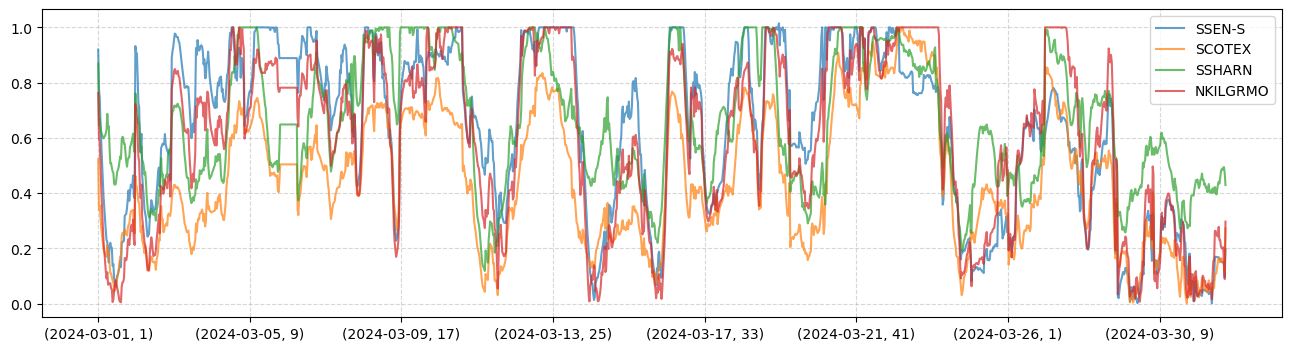

In [59]:

selection = ['SSEN-S', "SCOTEX", "SSHARN", "NKILGRMO"]

fig, ax = plt.subplots(1, 1, figsize=(16, 4))

share[selection].plot(ax=ax, alpha=0.7)

ax.grid(True, linestyle='--', alpha=0.5)
ax.set_axisbelow(True)

ax.legend()
plt.show()

In [62]:
(share['NKILGRMO'] > share['SSEN-S']).sum() / len(share)

0.3279569892473118

In [265]:
share.loc[(share[selection] == 1).any(axis=1)][selection]

Constraint Group,SSEN-S,SCOTEX,SSHARN,NKILGRMO
"(2024-03-04, 33)",1.000000,0.604882,0.829688,0.9676
"(2024-03-04, 34)",1.000000,0.612441,0.838594,1.0000
"(2024-03-04, 35)",1.000000,0.609291,0.835469,1.0000
"(2024-03-04, 43)",0.926087,0.732913,0.995938,1.0000
"(2024-03-04, 44)",0.912609,0.719055,1.000000,0.9936
...,...,...,...,...
"(2024-03-27, 25)",0.674545,0.690252,0.880234,1.0000
"(2024-03-27, 26)",0.673091,0.728235,0.895556,1.0000
"(2024-03-27, 27)",0.671636,0.728403,0.891345,1.0000
"(2024-03-27, 28)",0.667273,0.719496,0.880819,1.0000


In [136]:
print(wind[['p_nom', 'p', 'PN']].sum())
print(regions[['p_nom', 'p', 'PN']].sum())

p_nom    16.369000
p        14.698194
PN        4.927000
dtype: float64
p_nom    16.369000
p        14.698194
PN        4.927000
dtype: float64


In [14]:

get_bm_data(date, period)


NationalGridBmUnit
PINFD-5      0
PINFD-6      0
RUSHB-1      0
TYLNB-1      0
UNPKD-1      0
          ... 
SGRWO-2     39
SGRWO-1    153
LAGA-1     821
KEAD-2     834
HADHW-1     14
Name: PN, Length: 1879, dtype: int64